In [1]:
import numpy as np
import matplotlib.pyplot as plt

from water_balance import run_wbm
from water_balance_jax import run_wbm_jax

### test

In [2]:
name = 'illinois'

T = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_temperature.txt")
P = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_precip.txt")
lai = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_lai.txt")
soilMoist = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoist.txt")
soilMoistFrac = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoistFrac.txt")
Kc = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_kc.txt")

# Select correct latitiude
# SD: [44,-98]
# IA: [42,-93]
# IL: [40,-89]
lat_dict = {"southdakota":44., "iowa":42., "illinois":40.}
lat = lat_dict[name]

################
# Inputs
################
phi = lat          # Latitude
Ws_init = soilMoist[0]  # Initial soil moisture: take from WBM
Wi_init = 0.5           # Canopy water storage
Sp_init = 0.             # Snowpack

# Make dicts
initial_conditions = {}
initial_conditions["Ws_init"] = Ws_init
initial_conditions["Wi_init"] = Wi_init
initial_conditions["Sp_init"] = Sp_init

forcing_data = {}
forcing_data["prcp"] = P
forcing_data["tas"] = T

constants = {}
constants["rootDepth"] = 1000.
constants["phi"] = phi
constants["lai"] = lai
constants["nt"] = len(T)-1
constants["doy"] = np.arange(1,len(T)+1)

X = np.loadtxt('/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/param_values.txt', float)
iparam = 1100
parameters = {}
parameters["Ts"] = X[iparam][0]
parameters["Tm"] = X[iparam][1]
parameters['Clai'] = X[iparam][2]
parameters["awCap"] = X[iparam][3]
parameters["wiltingp"] = X[iparam][4]
parameters["alpha"] = X[iparam][5]
parameters["betaHBV"] = X[iparam][6]
parameters["Kmin"] = X[iparam][7]
parameters["Kmax"] = X[iparam][8]
parameters["Klai"] = X[iparam][9]

In [3]:
%%time
# run
out = run_wbm(
    initial_conditions=initial_conditions,
    forcing_data=forcing_data,
    parameters=[parameters[key] for key in parameters.keys()],
    constants=constants,
)

CPU times: user 6.11 ms, sys: 154 µs, total: 6.26 ms
Wall time: 6.24 ms


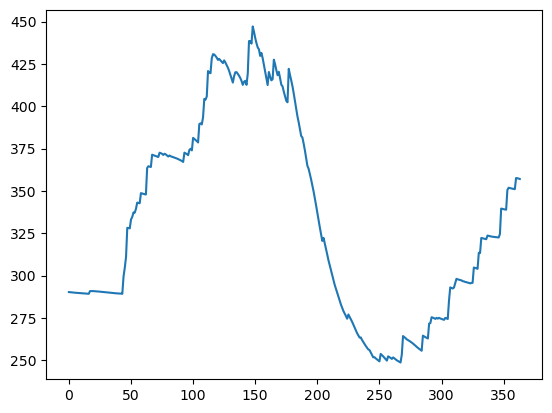

In [4]:
plt.plot(out)

In [5]:
%%time
# run
out_jax = run_wbm_jax(
    initial_conditions=[initial_conditions[key] for key in ['Ws_init', 'Wi_init', 'Sp_init']],
    forcing_data=[forcing_data[key] for key in ['tas','prcp']],
    parameters=[parameters[key] for key in ['Ts', 'Tm', 'Clai', 'awCap', 'wiltingp', 'alpha', 'betaHBV', 'Kmin', 'Kmax', 'Klai']],
    constants=[constants[key] for key in ['rootDepth','lai','phi','doy']],
)

CPU times: user 2.66 s, sys: 149 ms, total: 2.81 s
Wall time: 2.54 s


In [6]:
len(out)

364

In [7]:
len(out_jax)

364

In [8]:
out[:10]

array([290.30089865, 290.23526159, 290.16932152, 290.07181046,
       290.00304491, 289.91716989, 289.83841984, 289.78498868,
       289.74165651, 289.6918117 ])

In [9]:
out_jax[:10]

Array([290.3009 , 290.23514, 290.1691 , 290.0714 , 290.00253, 289.9165 ,
       289.83762, 289.7841 , 289.7407 , 289.69077], dtype=float32)

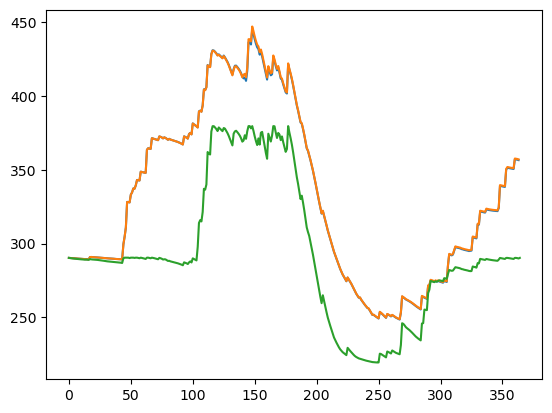

In [21]:
plt.plot(out_jax)
plt.plot(out)
plt.plot(soilMoist + parameters['wiltingp'])

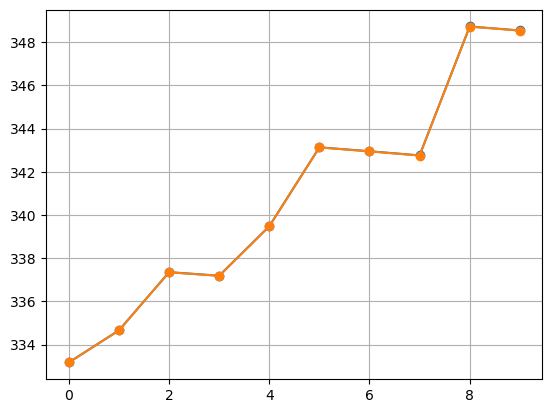

In [24]:
fig, ax = plt.subplots()
ax.plot(out_jax[50:60], 'o-')
ax.plot(out[50:60], 'o-')
# ax.plot(soilMoist[50:60] + parameters['wiltingp'], 'o-')
ax.grid()
plt.show()

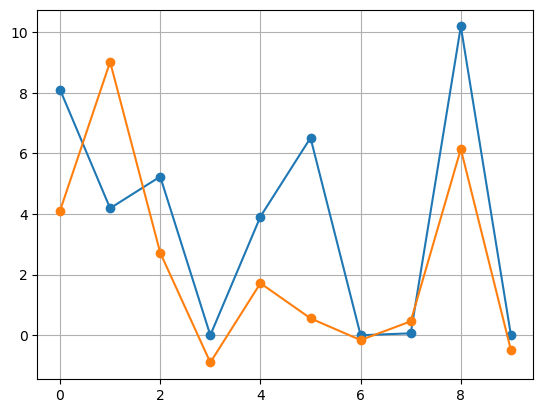

In [22]:
fig, ax = plt.subplots()
ax.plot(P[50:60], 'o-')
ax.plot(T[50:60], 'o-')
ax.grid()
plt.show()

In [304]:
def loss_fn(theta, tas, prcp, y):
  prediction = run_gr4j(theta, tas, prcp)
  return jnp.mean((prediction-y)**2)

In [344]:
@jax.jit
def update(theta, tas, prcp, y, lr=0.00001):
  return theta - lr * jax.grad(loss_fn)(theta, tas, prcp, y)

In [365]:
%%time
# theta = jnp.array([0.5, 11., 2.])

for _ in range(50000):
    theta = update(theta, T, P, ys)

CPU times: user 831 ms, sys: 9.33 ms, total: 841 ms
Wall time: 845 ms


In [367]:
theta = update(theta, T, P, ys)

In [368]:
theta

Array([ 0.5957835, 11.538452 ,  1.3691818], dtype=float32)

In [369]:
theta = update(theta, T, P, ys)

In [370]:
theta

Array([ 0.60198766, 11.542145  ,  1.3493962 ], dtype=float32)

In [371]:
theta = update(theta, T, P, ys)

In [372]:
theta

Array([ 0.59578335, 11.538452  ,  1.369182  ], dtype=float32)

b1: 0.60, b2: 11.54, b3: 1.35


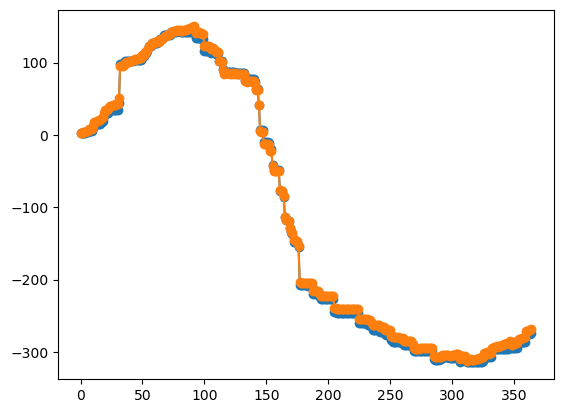

In [366]:
plt.plot(ys, 'o-')
plt.plot(run_gr4j(theta, T, P), 'o-')

b1, b2, b3 = theta
print(f"b1: {b1:<.2f}, b2: {b2:<.2f}, b3: {b3:<.2f}")

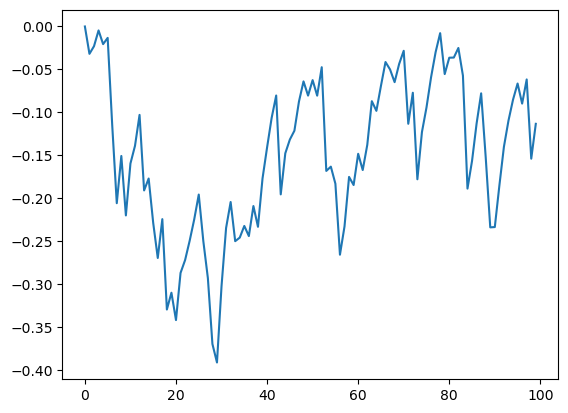

In [208]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(scale=0.1, size=(100,))
xs1 = np.random.normal(scale=0.1, size=(100,))
noise = np.random.normal(scale=0.01, size=(100,))
ys = np.zeros(100)
for t in range(1,len(ys)):
    c = np.zeros(100)
    if xs1[t] > 0.05:
        c[t] = c[t-1] + 1.
    if xs[t] > 0.:
        ys[t] = xs[t]*0.1 + ys[t-1]*0.8 - 0.1*c[t]
    elif xs[t] <= 0.:
        ys[t] = xs[t]*0.3 + ys[t-1]*0.8 - 0.1*c[t]
    
plt.plot(ys);

In [239]:
from numba import njit

### WBM

In [4]:
######################
# Select state
name = 'illinois'
######################

T = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_temperature.txt")
P = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_precip.txt")
lai = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_lai.txt")
soilMoist = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoist.txt")[0]
soilMoistFrac = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoistFrac.txt")
Kc = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_kc.txt")

# Select correct latitiude
# SD: [44,-98]
# IA: [42,-93]
# IL: [40,-89]
lat_dict = {"southdakota":44., "iowa":42., "illinois":40.}
lat = lat_dict[name]

################
# Inputs
################
phi = lat          # Latitude
Ws_init = soilMoist  # Initial soil moisture: take from WBM
Wi_init = 0.5           # Canopy water storage
Sp_init = 0.             # Snowpack

# Make dicts
initial_conditions = {}
initial_conditions["Ws_init"] = Ws_init
initial_conditions["Wi_init"] = Wi_init
initial_conditions["Sp_init"] = Sp_init

forcing_data = {}
forcing_data["prcp"] = P
forcing_data["tas"] = T

X = np.loadtxt('/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/param_values.txt', float)
iparam = 1000
parameters = {}
parameters["Ts"] = X[iparam][0]
parameters["Tm"] = X[iparam][1]
parameters['Clai'] = X[iparam][2]
parameters["awCap"] = X[iparam][3]
parameters["wiltingp"] = X[iparam][4]
parameters["alpha"] = X[iparam][5]
parameters["betaHBV"] = X[iparam][6]
parameters["Kmin"] = X[iparam][7]
parameters["Kmax"] = X[iparam][8]
parameters["Klai"] = X[iparam][9]

constants = {}
constants["lai"] = lai
constants["phi"] = phi
constants["nt"] = len(T)-1
constants["doy"] = np.arange(1,len(T)+1)
constants["rootDepth"] = 1000.

# run
out = wbm(
    initial_conditions=initial_conditions,
    forcing_data=forcing_data,
    parameters=[parameters[key] for key in parameters.keys()],
    constants=constants,
)

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
plt.plot(out)

In [5]:
def loss_fn(params, y):
  prediction = wbm(
      initial_conditions=initial_conditions,
      forcing_data=forcing_data,
      parameters=params,
      constants=constants,
  )

    
  return jnp.mean((prediction-y)**2)

In [ ]:
params = jnp.array([parameters[key] for key in parameters.keys()])

In [ ]:
jax.grad(loss_fn)(params, out)

In [123]:
@jax.jit
def update(params, Ws_out, lr=0.0001):
  return params - lr * jax.grad(loss_fn)(params, Ws_out)

In [124]:
params = jnp.array([100., 100., 1., 1.])

In [125]:
jax.grad(loss_fn)(params, Ws_out)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[1,1].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [53]:
params = jnp.array([100., 100., 1., 1.])

for _ in range(1000):
  params = update(params, Ws_out)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 0.